# Analysis of CRX motif importance
Calculate CRX importance scores in natural sequences based on model saliency maps and compare those scores to experimental observations.

Required inputs:
* `best_model.pth.tar`: The final regression model.
* `eLifeMotifs.meme`: The 8 PWMs used in the Friedman et al., eLife, 2021 study.
* `retinopathy_metadata.txt` and `retinopathy_data.parquet`: The data used in the Shepherdson et al., Genome Research, 2024 study.

Outputs:
* `genomicTestSetCrxImportanceDistr.svg`: Distribution of CRX importance scores for genomic test set.
* `genomicTestSetCrxEffectPredObs.svg`: Predicted and observed effect of mutating all CRX motifs from the genomic test set.
    * `genomicTestSetCrxEffectPredObs_byImp.svg`: Same, but only showing the sequences in the three bins, and colored by the importance bin.
* `genomicTestSetCrxImportanceBinned.svg`: Violin plots of genomic sequences binned by CRX importance showing the CRX importance, predicted effect of mutating motifs, and observed effect of mutating motifs.
* `crxMotifInstancePredObs.svg`: Boxplots of the predicted and observed effects of mutating individual CRX motifs in enhancers, stratified by the motif instance.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from src.mpra_tools import deeplift_utils, loaders, modeling, predicted_occupancy, plot_utils, fasta_utils
from src.selene_files.enhancer_resnet_regression import EnhancerResnet

from IPython.display import display

data_dir = "Data"
figures_dir = "Figures"
plot_utils.set_manuscript_params()

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
L = 164
model = loaders.load_cnn(
    os.path.join("ModelFitting", "CNN_Reg", "best_model", "best_model.pth.tar"),
     model=EnhancerResnet(L),
     eval_mode=True
)

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Find all instances of motifs in the retinopathy data and calculate their importance.

In [3]:
retinopathy_metadata = loaders.load_data(os.path.join(data_dir, "Downloaded", "retinopathy_metadata.txt"))
retinopathy_metadata = retinopathy_metadata.rename(columns = {"CRE_sequence": "seq"})

ewms = predicted_occupancy.read_pwm_to_ewm(os.path.join(data_dir, "Downloaded", "eLifeMotifs.meme"))
ewms = ewms.rename(lambda x: x.split("_")[0])
mu = 9

In [4]:
def find_sites(row, ewms=ewms, mu=mu):
    occupancy_landscape = predicted_occupancy.total_landscape(row["seq"], ewms, mu)
    sites = predicted_occupancy.get_occupied_sites_and_tfs(occupancy_landscape)
    result = pd.DataFrame(
        0,
        index=np.arange(len(sites)),
        columns=["seq_id", "seq", "motif", "start", "stop", "strand", "occupancy"]
    )
    for i, (start, motif_id) in enumerate(sites.items()):
        motif, strand = motif_id.split("_")
        if strand == "F":
            strand = "+"
        else:
            strand = "-"
        stop = start + len(ewms[motif])
        occupancy = occupancy_landscape.loc[start, motif_id]
        result.loc[i] = [row.name, row["seq"], motif, start, stop, strand, occupancy]
    return result

occupied_motifs = pd.concat(
    retinopathy_metadata.apply(find_sites, axis=1).tolist(),
    ignore_index=True
)

In [5]:
occupied_motifs["saliency_track"] = occupied_motifs.apply(
    lambda x: deeplift_utils.actual_saliency_track(x["seq"], model),
    axis=1
)
occupied_motifs["importance_score"] = occupied_motifs.apply(
    lambda x: deeplift_utils.motif_importance(x["saliency_track"], x["start"], x["stop"]),
    axis=1
)

Read MPRA data, make predictions on each sequence, calculate the predicted and observed LFC, and merge with motif information.

In [6]:
retinopathy_df = pd.read_parquet(os.path.join(data_dir, "Downloaded", "retinopathy_data.parquet"))
retinopathy_df = retinopathy_df[
    (retinopathy_df["library"] == "rho") &\
    (retinopathy_df["genotype"] == "WT")
].set_index("library_id")

# Get activity vs basal
retinopathy_df["activity_vs_basal"] = retinopathy_df["activity_mean"] / retinopathy_df.loc["basal", "activity_mean"]
retinopathy_df = retinopathy_df.drop(index="basal").reset_index()
retinopathy_df["expression_log2"] = retinopathy_df["activity_vs_basal"].apply(np.log2)

# Rename activity classes and a few columns
retinopathy_df["activity_class"] = retinopathy_df["activity_class"].replace({
    "strong_enhancer": "StrongEnhancer",
    "weak_enhancer": "WeakEnhancer",
    "inactive": "Inactive",
    "weak_silencer": "Silencer",
    "strong_silencer": "Silencer"
})
retinopathy_df = retinopathy_df.rename(columns={
    "CRE_sequence": "seq",
    "activity_class": "activity_bin",
})

retinopathy_df = pd.merge(retinopathy_df, retinopathy_metadata, on="library_id")

In [7]:
retinopathy_df["activity_bin"].value_counts(normalize=True)

WeakEnhancer      0.553123
Silencer          0.217298
Inactive          0.151895
StrongEnhancer    0.077683
Name: activity_bin, dtype: float64

In [8]:
seqs_hot = modeling.one_hot_encode(retinopathy_df["seq"])
retinopathy_df["pred_activity"] = modeling.cnn_predict_batches(
    model,
    modeling.batch(seqs_hot),
).flatten()

In [9]:
wt_vs_mut_df = pd.merge(
    retinopathy_df[retinopathy_df["variant_type"] == "wildtype"],
    retinopathy_df[retinopathy_df["variant_type"] == "allCrxSites"].drop(
        columns=["epigenome_group", "atac_crx_dependent", "chrom", "start", "stop", "num_crx_sites"]
    ),
    on="chip_peak_id",
    suffixes=["_WT", "_MUT"]
)

wt_vs_mut_df["obs_lfc"] = wt_vs_mut_df["expression_log2_WT"] - wt_vs_mut_df["expression_log2_MUT"]
wt_vs_mut_df["pred_lfc"] = wt_vs_mut_df["pred_activity_WT"] - wt_vs_mut_df["pred_activity_MUT"]

wt_vs_mut_df = pd.merge(
    wt_vs_mut_df,
    occupied_motifs.rename(columns={
        "start": "motif_start",
        "stop": "motif_stop",
    }),
    left_on="chip_peak_id",
    right_on="seq_id",
    how="left"
)

wt_vs_mut_df

,library_id_WT,library_WT,genotype_WT,activity_mean_WT,activity_std_WT,n_observations_WT,activity_mu_WT,activity_sigma_WT,pvalue_WT,qvalue_WT,...,pred_lfc,seq_id,seq,motif,motif_start,motif_stop,strand,occupancy,saliency_track,importance_score
0,CRX.1003,rho,WT,0.212773,0.069493,12.0,-1.598208,0.318364,4.222015e-02,5.154038e-02,...,0.028918,CRX.1003,CCAGCGTTCCTCCCATCTGTAGCAGTCAGGGTTCTTAAGTAGCAAA...,CRX,64,72,-,0.641077,"[-0.038069364, -0.019352105, -0.020726535, 0.0...",-0.123680
1,CRX.1003,rho,WT,0.212773,0.069493,12.0,-1.598208,0.318364,4.222015e-02,5.154038e-02,...,0.028918,CRX.1003,CCAGCGTTCCTCCCATCTGTAGCAGTCAGGGTTCTTAAGTAGCAAA...,NDF1,110,120,+,0.804350,"[-0.038069364, -0.019352105, -0.020726535, 0.0...",2.806685
2,CRX.1004,rho,WT,1.056873,0.300882,12.0,0.016349,0.279162,8.650884e-13,2.948816e-12,...,0.933911,CRX.1004,CTAACTTCCGTATCCACTGCCCCCACCCCCACCCCTGTGTCCTCAC...,MAZ,19,30,-,0.866096,"[0.0031529046, 0.02367922, 0.015406864, -0.013...",0.267952
3,CRX.1004,rho,WT,1.056873,0.300882,12.0,0.016349,0.279162,8.650884e-13,2.948816e-12,...,0.933911,CRX.1004,CTAACTTCCGTATCCACTGCCCCCACCCCCACCCCTGTGTCCTCAC...,MAZ,25,36,-,0.671315,"[0.0031529046, 0.02367922, 0.015406864, -0.013...",0.156446
4,CRX.1004,rho,WT,1.056873,0.300882,12.0,0.016349,0.279162,8.650884e-13,2.948816e-12,...,0.933911,CRX.1004,CTAACTTCCGTATCCACTGCCCCCACCCCCACCCCTGTGTCCTCAC...,CRX,53,61,+,0.884691,"[0.0031529046, 0.02367922, 0.015406864, -0.013...",0.628905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6350,CRX.986,rho,WT,0.077007,0.054505,12.0,-2.766921,0.637274,5.762969e-06,1.034271e-05,...,-0.250726,CRX.986,CAGTTAGCATCCCTCCCTACAAGTCAAGTTCTTAGAAGCTCACTTG...,CRX,144,152,-,0.924552,"[0.0020016246, 0.14286113, 0.19791228, 0.08359...",-0.572783
6351,CRX.99,rho,WT,0.135100,0.239931,12.0,-2.713783,1.193348,2.389456e-03,3.292559e-03,...,-0.351783,CRX.99,GGAGTCAGTTTTCTCCTTTGACCTATAAGTGGATTCTGGGGATCAA...,RORB,17,28,-,0.895124,"[-0.026200164, -0.09801117, -0.08601449, 0.030...",1.408703
6352,CRX.99,rho,WT,0.135100,0.239931,12.0,-2.713783,1.193348,2.389456e-03,3.292559e-03,...,-0.351783,CRX.99,GGAGTCAGTTTTCTCCTTTGACCTATAAGTGGATTCTGGGGATCAA...,CRX,38,46,-,0.988359,"[-0.026200164, -0.09801117, -0.08601449, 0.030...",-1.078395
6353,CRX.99,rho,WT,0.135100,0.239931,12.0,-2.713783,1.193348,2.389456e-03,3.292559e-03,...,-0.351783,CRX.99,GGAGTCAGTTTTCTCCTTTGACCTATAAGTGGATTCTGGGGATCAA...,CRX,58,66,-,0.912741,"[-0.026200164, -0.09801117, -0.08601449, 0.030...",-0.332292


Calculate the summed total importance of CRX motifs in the sequence.

In [10]:
def get_total_crx_imp(df):
    if len(df) == 1:
        return df[["importance_score", "obs_lfc", "pred_lfc"]].squeeze()
    
    imp = df["importance_score"].mean()
    imp = df["importance_score"].sum()
    # Note pred and obs are the same for all rows of the df so we can just take the first one
    row = df.iloc[0]
    obs = row["obs_lfc"]
    pred = row["pred_lfc"]
    return pd.Series({
        "importance_score": imp,
        "obs_lfc": obs,
        "pred_lfc": pred
    })

crx_imp_df = wt_vs_mut_df[
    wt_vs_mut_df["motif"] == "CRX"
].groupby("seq_id").apply(get_total_crx_imp)

count    1723.000000
mean        0.539595
std         1.848082
min       -12.268122
10%        -1.550594
25%        -0.091026
50%         0.670908
75%         1.536670
90%         2.466232
max         6.922724
Name: importance_score, dtype: float64

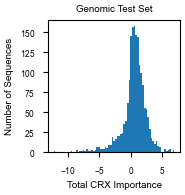

In [11]:
fig, ax = plt.subplots(figsize=plot_utils.get_figsize(frac=0.25, aspect=1))
ax.hist(
    crx_imp_df["importance_score"],
    bins="auto"
)
ax.set_xlabel("Total CRX Importance")
ax.set_ylabel("Number of Sequences")
ax.set_title("Genomic Test Set")
plot_utils.save_fig(fig, os.path.join(figures_dir, "genomicTestSetCrxImportanceDistr"))

crx_imp_df["importance_score"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

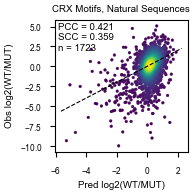

In [12]:
fig, ax, corrs = plot_utils.scatter_with_corr(
    crx_imp_df["pred_lfc"],
    crx_imp_df["obs_lfc"],
    "Pred log2(WT/MUT)",
    "Obs log2(WT/MUT)",
    loc="upper left",
    colors="density",
    figax=plt.subplots(figsize=plot_utils.get_figsize(frac=0.25, aspect=1))
)
ax.plot(ax.get_xlim(), ax.get_xlim(), color="k", linestyle="--")
ax.set_title("CRX Motifs, Natural Sequences")
plot_utils.save_fig(fig, os.path.join(figures_dir, "genomicTestSetCrxEffectPredObs"))

Bin the sequences by CRX importance into most repressive, most activating, not importance (absolute importance < 0.2), and other. Then replot the predicted and observed effects stratified by importance.

In [13]:
quantiles = crx_imp_df["importance_score"].quantile(q=[0.1, 0.9])
def bin_imp_score(score, quantiles=quantiles):
    if score < quantiles[0.1]:
        return "Negative"
    elif score > quantiles[0.9]:
        return "Positive"
    elif abs(score) < 0.5:
        return "Not\nimportant"
    else:
        return np.nan
    
crx_imp_df["importance_bin"] = crx_imp_df["importance_score"].apply(bin_imp_score)
crx_imp_df["importance_bin"] = pd.Categorical(
    crx_imp_df["importance_bin"],
    categories=["Negative", "Not\nimportant", "Positive"],
    ordered=True
)
crx_imp_df["importance_bin"].value_counts(dropna=False)

NaN               925
Not\nimportant    452
Negative          173
Positive          173
Name: importance_bin, dtype: int64

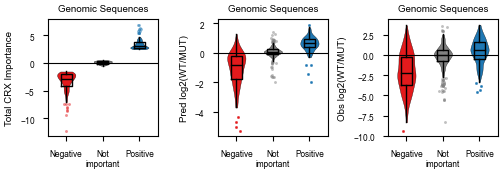

In [14]:
color_scheme = plot_utils.get_class_colors()[["Silencer", "Inactive", "StrongEnhancer"]]
color_scheme["Inactive"] = "#808080"
color_scheme = color_scheme.rename({
    "Silencer": "Negative",
    "Inactive": "Not\nimportant",
    "StrongEnhancer": "Positive"
})

grouper = crx_imp_df.groupby("importance_bin")

fig, ax_list = plt.subplots(ncols=3, figsize=plot_utils.get_figsize(frac=0.75, aspect=0.36))
for ax, col, name in zip(
    ax_list,
    ["importance_score", "pred_lfc", "obs_lfc"],
    ["Total CRX Importance", "Pred log2(WT/MUT)", "Obs log2(WT/MUT)"]
):
    plot_utils.violin_plot_groupby(
        grouper[col],
        name,
        figax=(fig, ax),
        class_colors=color_scheme.values
    )
    ax.axhline(0, color="k")
    ax.set_title("Genomic Sequences")
    
plot_utils.save_fig(fig, os.path.join(figures_dir, "genomicTestSetCrxImportanceBinned"))

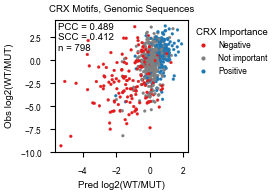

In [15]:
import matplotlib as mpl
import matplotlib.lines as mlines
binned_imp_df = crx_imp_df[crx_imp_df["importance_bin"].notna()]

fig, ax, corrs = plot_utils.scatter_with_corr(
    binned_imp_df["pred_lfc"],
    binned_imp_df["obs_lfc"],
    "Pred log2(WT/MUT)",
    "Obs log2(WT/MUT)",
    loc="upper left",
    colors=binned_imp_df["importance_bin"].apply(lambda x: color_scheme[x]),
    figax=plt.subplots(figsize=plot_utils.get_figsize(frac=0.25, aspect=1)),
    # alpha=0.5
)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    handles=[
        mlines.Line2D([], [], color="white", marker="o", markerfacecolor=c,
                      markersize=3,
                      # One line
                      label=l.replace("\n", " ")
        )
        for l, c in color_scheme.items()
    ],
    frameon=False,
    title="CRX Importance"
)

ax.set_title("CRX Motifs, Genomic Sequences")
plot_utils.save_fig(fig, os.path.join(figures_dir, "genomicTestSetCrxEffectPredObs_byImp"))

## Single motif deletions

In [16]:
single_deletion_df = pd.merge(
    retinopathy_df[retinopathy_df["variant_type"] == "wildtype"],
    retinopathy_df[retinopathy_df["variant_type"] == "singleCrxSite"].drop(
        columns=["epigenome_group", "atac_crx_dependent", "chrom", "start", "stop", "num_crx_sites"]
    ),
    on="chip_peak_id",
    suffixes=["_WT", "_MUT"]
)

single_deletion_df["obs_lfc"] = single_deletion_df["expression_log2_WT"] - single_deletion_df["expression_log2_MUT"]
single_deletion_df["pred_lfc"] = single_deletion_df["pred_activity_WT"] - single_deletion_df["pred_activity_MUT"]

# Due to some discrepancies between the FIMO-identified motifs used in the library design
# and the P_occ scan, we need to shortlist the motif hits. Since higher occupancy scores
# will also have higher FIMO scores, the 2 highest scoring CRX sites in a sequence corresponds
# to those that were mutated in the library design. Furthermore, the highest-scoring
# motif has the suffix _1 in the seq_id and the second motif has the suffix _2.
crx_motifs = occupied_motifs[occupied_motifs["motif"] == "CRX"].rename(columns={
        "start": "motif_start",
        "stop": "motif_stop",
    })

def get_motif_match(row):
    seq = row["seq"]
    match = seq[row["motif_start"]:row["motif_stop"]]
    if row["strand"] == "-":
        match = fasta_utils.rev_comp(match)
    return match

crx_motifs["motif_match"] = crx_motifs.apply(get_motif_match, axis=1)

def get_best_two_motifs(group):
    best = group.sort_values(by="occupancy", ascending=False).head(2)
    best["motif_rank"] = best["occupancy"].rank(ascending=False).astype(int)
    return best
    
crx_motifs = crx_motifs.groupby("seq_id").apply(
    get_best_two_motifs).reset_index(drop=True).drop(columns="seq")

single_deletion_df = pd.merge(
    single_deletion_df,
    crx_motifs,
    left_on="chip_peak_id",
    right_on="seq_id",
    how="left"
)

# At this point, each WT sequence is represented by 4 rows, which corresponds to two
# different single mutants and each motif identified with P_occ. Now we need to figure
# out if the matched motif in a row corresponds to the mutated motif.
single_deletion_df = single_deletion_df[
    single_deletion_df["motif_rank"] == single_deletion_df["library_id_MUT"].str.split("_").str[1].astype(int)
].reset_index(drop=True)

single_deletion_df

,library_id_WT,library_WT,genotype_WT,activity_mean_WT,activity_std_WT,n_observations_WT,activity_mu_WT,activity_sigma_WT,pvalue_WT,qvalue_WT,...,seq_id,motif,motif_start,motif_stop,strand,occupancy,saliency_track,importance_score,motif_match,motif_rank
0,CRX.1183,rho,WT,0.287536,0.239704,12.0,-1.510240,0.726405,5.141037e-01,5.486734e-01,...,CRX.1183,CRX,87,95,+,0.999483,"[-0.05604365, 8.035218e-05, -0.017323906, 0.00...",0.043300,TTAATCCA,1
1,CRX.1183,rho,WT,0.287536,0.239704,12.0,-1.510240,0.726405,5.141037e-01,5.486734e-01,...,CRX.1183,CRX,53,61,+,0.995114,"[-0.05604365, 8.035218e-05, -0.017323906, 0.00...",0.453425,ATAATCTG,2
2,CRX.1252,rho,WT,0.691522,0.317290,12.0,-0.464387,0.437096,7.907928e-06,1.400386e-05,...,CRX.1252,CRX,59,67,+,0.999726,"[0.010004551, 0.018536428, -0.014530088, -0.01...",1.440183,CTAATCCC,1
3,CRX.1252,rho,WT,0.691522,0.317290,12.0,-0.464387,0.437096,7.907928e-06,1.400386e-05,...,CRX.1252,CRX,66,74,-,0.894606,"[0.010004551, 0.018536428, -0.014530088, -0.01...",-0.502648,TTGATCTG,2
4,CRX.1264,rho,WT,3.305071,0.765125,12.0,1.169355,0.228486,3.574553e-23,2.782656e-22,...,CRX.1264,CRX,97,105,-,0.969370,"[-0.005109234, -0.035625048, -0.02582123, -0.0...",0.739572,TTAATACT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,CRX.925,rho,WT,1.053625,0.581409,12.0,-0.080674,0.515579,1.074875e-06,2.081782e-06,...,CRX.925,CRX,1,9,+,0.875228,"[0.124763094, 0.35705188, 0.023210071, 0.24426...",0.629061,TTTATCCG,2
196,CRX.967,rho,WT,3.803829,1.732270,12.0,1.241777,0.434122,2.932058e-12,9.577701e-12,...,CRX.967,CRX,74,82,-,0.999427,"[-0.049934164, -0.009415997, 0.02296285, 0.028...",0.685611,CTAATCCT,1
197,CRX.967,rho,WT,3.803829,1.732270,12.0,1.241777,0.434122,2.932058e-12,9.577701e-12,...,CRX.967,CRX,62,70,+,0.996956,"[-0.049934164, -0.009415997, 0.02296285, 0.028...",0.581981,ATAATCTC,2
198,CRX.978,rho,WT,1.046316,1.305171,12.0,-0.423946,0.968733,6.437305e-03,8.523174e-03,...,CRX.978,CRX,84,92,-,0.999877,"[0.01837316, 0.013795317, 0.0040625813, 0.0006...",1.811426,TTAATCCC,1


Assign motif classes/instances. Then pull out the enhancers and show the importance score vs the observed effects.

Frequency of motif instances in the 100 sequences:


TAATCC    65
TAATCD    31
TAAG      54
TGAT      18
NaN       32
Name: motif_class, dtype: int64

Frequency of motif instances in the 68 enhancers:


TAATCC    44
TAATCD    16
TAAG      40
TGAT      15
NaN       21
Name: motif_class, dtype: int64

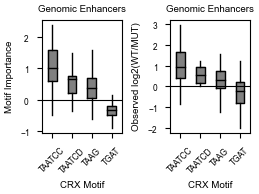

In [17]:
def assign_motif_class(motif):
    if "TAATCC" in motif:
        result = "TAATCC"
    elif "TAATC" in motif:
        result = "TAATCD"
    elif "TAAG" in motif:
        result = "TAAG"
    elif "TGAT" in motif:
        result = "TGAT"
    else:
        result = np.nan
    return result

single_deletion_df["motif_class"] = single_deletion_df["motif_match"].apply(assign_motif_class)
single_deletion_df["motif_class"] = pd.Categorical(
    single_deletion_df["motif_class"],
    categories=["TAATCC", "TAATCD", "TAAG", "TGAT"],
    ordered=True
)
print("Frequency of motif instances in the 100 sequences:")
display(single_deletion_df["motif_class"].value_counts(dropna=False, sort=False))

enhancer_singles = single_deletion_df[single_deletion_df["activity_bin_WT"].str.contains("Enhancer")]
n = len(enhancer_singles["library_id_WT"].unique())
print(f"Frequency of motif instances in the {n} enhancers:")
display(enhancer_singles["motif_class"].value_counts(dropna=False, sort=False))

grouper = enhancer_singles.groupby("motif_class")

fig, ax_list = plt.subplots(ncols=2, figsize=plot_utils.get_figsize(frac=0.4, aspect=0.75))
for ax, col, ylab in zip(
    ax_list,
    ["importance_score", "obs_lfc"],
    ["Motif Importance", "Observed log2(WT/MUT)"]
):
    names, data = zip(*[(name, i[col]) for name, i in grouper])
    bplot = ax.boxplot(
        data,
        labels=names,
    )
    for patch in bplot["boxes"]:
        ax.add_artist(mpatches.PathPatch(patch.get_path(), color="grey"))
    
    ax.set_xlabel("CRX Motif")
    ax.set_ylabel(ylab)
    ax.set_title("Genomic Enhancers")
    ax.axhline(0, color="k")
    plot_utils.rotate_ticks(ax.get_xticklabels(), 45)
    
fig.tight_layout()
plot_utils.save_fig(fig, os.path.join(figures_dir, "crxMotifInstancePredObs"))